# RL for imbalanced 10-class classification

## Imports and data fetch

In [1]:
import os
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import gym

from datetime import datetime

from scipy.stats import zscore, gmean

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

tf.test.gpu_device_name()

2023-01-05 20:36:05.870751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 20:36:06.759790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-05 20:36:06.759877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-05 20:36:06.759885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

'/device:GPU:0'

In [2]:
train  = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')

df = pd.concat([train,test]).drop(['id', 'label'], axis=1)

## Data preprocessing

In [3]:
NOMINAL_COLS = ['proto', 'service', 'state']
BINARY_COLS = ['is_sm_ips_ports', 'is_ftp_login']

for name in df.columns:
    if name == "attack_cat" or name in NOMINAL_COLS or name in BINARY_COLS:
        pass
    else:
        df[name] = zscore(df[name])

for name in NOMINAL_COLS:
    df = pd.concat([df, pd.get_dummies(df[name], prefix=name)],axis=1)
    df.drop(name,axis=1,inplace=True)

## Reward bias for RL

In [4]:
attack_cat_list = np.unique(df['attack_cat'])

rw_factor = compute_class_weight(class_weight='balanced',
                                 classes=attack_cat_list,
                                 y=df['attack_cat'])

minority_threshold = gmean(rw_factor)

minority_classes = []

for idx, attack in enumerate(attack_cat_list):
    if rw_factor[idx] > minority_threshold:
        minority_classes.append(idx)

In [5]:
display(minority_threshold)
display(rw_factor)

2.9957855137446554

array([  9.62543892,  11.0636754 ,   1.57569253,   0.57871533,
         1.06274437,   0.43769088,   0.27706774,   1.84223207,
        17.05314361, 148.08793103])

## Data normalization, split, optional smote, shuffle 

In [6]:
x = df.drop(['attack_cat'], axis=1).values

# Make the values [0, 1] for the RL environment
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

dummies = pd.get_dummies(df['attack_cat'])
attack_cat_list = list(dummies.columns)
y = dummies.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

## Benchmark functions

In [8]:
models_benchmark = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score'])

def getMetrics(model_name, y_truth, y_pred, average):
    # Macro-avg is recommended to keep minority classes relevant
    # Weighted-avg is recommended to keep majority classes relevant
    print(f'Metrics {average}-averaged')
    acc = metrics.accuracy_score(y_truth, y_pred)
    rec = metrics.recall_score(y_truth, y_pred, average=average, zero_division=0)
    pre = metrics.precision_score(y_truth, y_pred, average=average, zero_division=0)
    f1s = metrics.f1_score(y_truth, y_pred, average=average, zero_division=0)

    models_benchmark.loc[model_name] = [acc, rec, pre, f1s]
    display(models_benchmark.loc[model_name])
    return

def getCM(model_name, y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10,10))
    plt.title(f'{model_name}', fontsize=20)

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=attack_cat_list, yticklabels=attack_cat_list)

    plt.xticks(rotation=45)
    plt.ylabel('Real outcome', fontsize=16)
    plt.xlabel('Predicted outcome', fontsize=16)
    plt.ioff()
    plt.show()
    return

## Environment for RL

In [9]:
class CustomEnv(gym.Env):
    def __init__(self, dataset=(x_train, y_train), rw_factor=rw_factor, minority_classes=minority_classes):
        
        super().__init__()

        self.x, self.y = dataset
        self.rw_factor = rw_factor
        self.idx = 0
        self.action_space = gym.spaces.Discrete(self.y.shape[1])
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=(self.x.shape[1], ),
                                                dtype=np.float32)
        
        self.minority_classes = minority_classes
        self.step_counter = 0
        self.max_steps = len(self.x)

    def step(self, action):
        done = False
        
        # Reward management
        if int(action == self.expected_action):
            reward = self.rw_factor[self.expected_action]
        else:
            reward = -self.rw_factor[self.expected_action]
            # Done management 1 -> Stop progressing a bad guess is taken
            # on data from a minority class
            if self.expected_action in self.minority_classes:
                done = True
                
        # Observation management
        self.idx += 1
        
        if self.idx >= len(self.x):
            self.idx = 0
        
        obs = self.seq_observation()

        # Done management 2 -> If a whole sweep of X is achieved
        self.step_counter += 1
        
        if self.step_counter >= self.max_steps:
            done = True

        return obs, reward, done, {}

    def reset(self):
        # Start from a random position in X
        self.step_counter = 0
        self.idx = random.randint(0, len(self.x) - 1)
        obs = self.seq_observation()
        return obs
    
    def seq_observation(self):        
        obs = self.x[self.idx]
        self.expected_action = int(np.argmax(self.y[self.idx]))
        return obs

## Callback for best model auto-save

In [10]:
class SaveBest(BaseCallback):
    def __init__(self, check_freq: int, max_failure_threshold: int, log_dir: str, verbose: int = 0):
        super(SaveBest, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.no_best_count = 0
        self.max_failure_threshold = max_failure_threshold
    
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                
                mean_reward = np.mean(y[-100:])
                
                if mean_reward > self.best_mean_reward:
                    self.no_best_count = 0
                    self.best_mean_reward = mean_reward
                    y_train_pred = self.model.predict(x_train)[0]
                    getMetrics(f'Training metrics', np.argmax(y_train, axis=1), y_train_pred, 'macro')
                    print('\n')

                    if self.verbose >= 0:
                        print(f"Num timesteps: {self.num_timesteps}")
                        print(f"Mean reward per episode: {mean_reward:.2f}")
                        print(f"Saving new best model to {self.save_path}")
                        print('----- ----- -----')
                        
                    self.model.save(self.save_path)   
                    
                else:
                    self.no_best_count += 1
    
                    if self.no_best_count >= self.max_failure_threshold:
                        print(f'Restarting best reward: {self.max_failure_threshold} evaluations without improvement')
                        self.best_mean_reward = -np.inf
                        self.no_best_count = 0
        return True

In [11]:
log_dir = './tmp_log_dqn/'
os.makedirs(log_dir, exist_ok=True)

train_env = CustomEnv()
train_env = Monitor(train_env, log_dir)

train_env.reset()

print(x_train.shape)

(206138, 196)


## Model creation / load / manual save

In [12]:
# Choose between PPO or A2C, since SB3 only provides vanilla DQN

ALGO = 'DQN'
callback = SaveBest(check_freq=1000, max_failure_threshold=1000, log_dir=log_dir)

In [13]:
model = DQN(policy='MlpPolicy', 
            env=train_env, 
            tensorboard_log=f'./{ALGO}')

In [14]:
# Change the name to load proper model
# model = PPO.load(path=f'./tmp_log/best_model.zip', env=train_env)

In [15]:
# For manual saving after training

# tail = datetime.today().strftime('%d-%m_%H-%M')

# model.save(f'./tmp_log/{ALGO}_MANUAL_{tail}')

## Model training

In [21]:
# Min 5M timesteps for relevant results if training a new model

EPOCHS = 1
TIMESTEPS = 500e3

for i in range(1, EPOCHS+1):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f'{ALGO}_TB_LOG', callback=callback)

Metrics macro-averaged


Accuracy     0.782194
Recall       0.575484
Precision    0.542019
F1-score     0.540178
Name: Training metrics, dtype: float64



Num timesteps: 32102000
Mean reward per episode: 16.08
Saving new best model to ./tmp_log_dqn/best_model
----- ----- -----
Metrics macro-averaged


Accuracy     0.772963
Recall       0.574409
Precision    0.519819
F1-score     0.512178
Name: Training metrics, dtype: float64



Num timesteps: 32135000
Mean reward per episode: 17.79
Saving new best model to ./tmp_log_dqn/best_model
----- ----- -----


## Compute metrics and CM for the current model on test split

Metrics macro-averaged


Accuracy     0.769982
Recall       0.574642
Precision    0.529209
F1-score     0.526441
Name: RUN, dtype: float64

----- ----- -----
Metrics weighted-averaged


Accuracy     0.769982
Recall       0.769982
Precision    0.830571
F1-score     0.785713
Name: RUN, dtype: float64

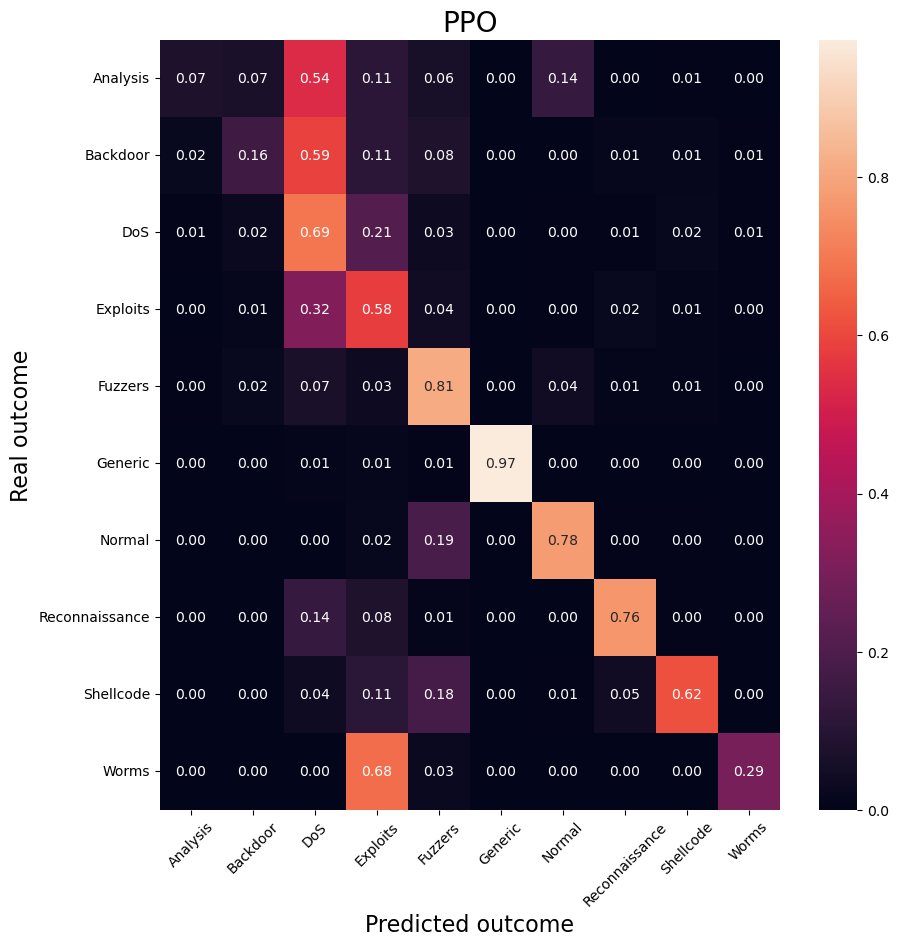

In [22]:
y_pred = model.predict(x_test)[0]

getMetrics('RUN', np.argmax(y_test, axis=1), y_pred, 'macro')
print('----- ----- -----')
getMetrics('RUN', np.argmax(y_test, axis=1), y_pred, 'weighted')
getCM('PPO', np.argmax(y_test, axis=1), y_pred)